# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [5]:
with pd.HDFStore('../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [6]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
with pd.HDFStore('../data/assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

## Compute Inputs

### Compute Returns

In [8]:
start = 2008
end = 2017

In [9]:
prices.head()

ticker,WDAY,CAT,IT,AMGN,UDR,MS,WAT,EL,HSIC,EQT,...,NKE,JBHT,XEL,BIIB,PRU,O,EXPE,USB,MTB,POOL
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,1.578370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,1.593539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,1.634945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,1.650114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,1.660363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create month-end monthly returns and drop dates that have no observations:

In [10]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAT     521 non-null    float64
 1   IT      521 non-null    float64
 2   AMGN    521 non-null    float64
 3   UDR     521 non-null    float64
 4   MS      521 non-null    float64
 5   WAT     521 non-null    float64
 6   EL      521 non-null    float64
 7   HSIC    521 non-null    float64
 8   EQT     521 non-null    float64
 9   ESS     521 non-null    float64
 10  CPT     521 non-null    float64
 11  HOLX    521 non-null    float64
 12  RJF     521 non-null    float64
 13  ACGL    521 non-null    float64
 14  TXT     521 non-null    float64
 15  COF     521 non-null    float64
 16  A       521 non-null    float64
 17  NTAP    521 non-null    float64
 18  NKE     521 non-null    float64
 19  JBHT    521 non-null    float64
 20  XEL     521 non-null    float64
 21  BIIB    

In [11]:
weekly_returns.head()

ticker,CAT,IT,AMGN,UDR,MS,WAT,EL,HSIC,EQT,ESS,...,NKE,JBHT,XEL,BIIB,PRU,O,EXPE,USB,MTB,POOL
date,,,,,,,,,,,,,,,,,,,,,
2008-01-13,-0.036772,0.006258,0.062946,0.047130,-0.012906,0.015353,-0.074278,0.034284,0.029566,0.038181,...,-0.016845,0.012784,0.023129,0.068816,0.010061,0.019426,-0.105210,0.013927,-0.027686,-0.012432
2008-01-20,-0.042994,-0.084577,-0.003570,0.018081,-0.067783,-0.069504,0.000258,0.032163,-0.072701,-0.008343,...,-0.069193,0.041938,-0.055408,0.015080,-0.124343,-0.069727,-0.110775,0.011390,-0.000814,-0.015326
2008-01-27,0.049674,-0.024457,0.014542,0.087321,0.083795,-0.220675,0.012123,-0.069952,-0.015484,0.088786,...,-0.008850,0.084408,-0.049273,-0.016525,-0.007750,0.090317,-0.009354,0.091752,0.137875,0.169539
2008-02-03,0.088427,0.058496,-0.016203,0.055354,-0.013091,0.062204,0.142457,-0.008889,0.104917,0.102389,...,0.116250,0.113514,0.045903,0.048201,0.074452,0.080102,0.006438,0.031553,0.121407,0.149240
2008-02-10,-0.052258,0.098684,-0.016892,-0.026655,-0.104870,-0.007588,-0.028552,-0.001380,0.033153,-0.048607,...,-0.029915,-0.029805,-0.027371,-0.004210,-0.157346,-0.081909,0.070789,-0.048824,-0.054663,-0.124069


### Set  Parameters

In [12]:
stocks = weekly_returns.columns

In [13]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(28, 521)

In [14]:
NUM_PF = 100_000 # no of portfolios to simulate

In [15]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [16]:
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

### Compute Mean Returns, Covariance and Precision Matrix

In [17]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

In [18]:
mean_returns.head(50)

ticker
CAT     0.003238
IT      0.004745
AMGN    0.003446
UDR     0.003311
MS      0.003625
WAT     0.002454
EL      0.004473
HSIC    0.002122
EQT     0.001513
ESS     0.003323
CPT     0.003565
HOLX    0.001491
RJF     0.004142
ACGL    0.003016
TXT     0.002443
COF     0.004193
A       0.002914
NTAP    0.002910
NKE     0.003657
JBHT    0.003986
XEL     0.002493
BIIB    0.004388
PRU     0.003585
O       0.003485
EXPE    0.003547
USB     0.002907
MTB     0.003085
POOL    0.005128
dtype: float64

The precision matrix is the inverse of the covariance matrix:

In [19]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

### Risk-Free Rate

Load historical 10-year Treasury rate:

In [20]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

In [21]:
rf_rate = treasury_10yr_monthly.mean()

## Simulate Random Portfolios

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [22]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [23]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [24]:
df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.589668e-02,3.561045e-02,3.567347e-02,3.528123e-02,3.618813e-02,3.547386e-02,3.600685e-02,3.577013e-02,3.496518e-02,3.561671e-02,...,3.524950e-02,3.610971e-02,3.578975e-02,3.464950e-02,3.597421e-02,3.592630e-02,3.537808e-02,3.648897e-02,3.636171e-02,3.561415e-02
std,1.199444e-01,1.192469e-01,1.192915e-01,1.186858e-01,1.203729e-01,1.189204e-01,1.211875e-01,1.197825e-01,1.177705e-01,1.197610e-01,...,1.178849e-01,1.207737e-01,1.193385e-01,1.166488e-01,1.204819e-01,1.198462e-01,1.194514e-01,1.214623e-01,1.214140e-01,1.204221e-01
min,1.035412e-101,1.490935e-94,7.762252e-102,4.166465e-102,4.894237e-125,6.728303e-119,7.078866e-103,2.464090e-105,1.569720e-96,1.834136e-112,...,1.780687e-96,7.472314e-96,1.910334e-117,7.255225e-117,6.794696e-98,2.687215e-89,1.018372e-117,2.825634e-98,6.523211e-117,5.282019e-137
25%,5.384734e-13,6.334993e-13,5.100822e-13,5.812376e-13,5.931167e-13,6.345348e-13,6.827859e-13,6.288266e-13,5.414450e-13,4.795758e-13,...,6.461624e-13,5.667643e-13,6.621791e-13,6.129493e-13,5.616409e-13,5.382945e-13,5.341862e-13,5.654731e-13,6.138029e-13,5.783407e-13
50%,5.939619e-07,6.791383e-07,5.681411e-07,5.795121e-07,6.119447e-07,6.633717e-07,6.629626e-07,6.108373e-07,6.103964e-07,5.610949e-07,...,5.536879e-07,5.932105e-07,6.472786e-07,5.680932e-07,6.330097e-07,6.157646e-07,5.679543e-07,6.829195e-07,6.014063e-07,6.183092e-07
75%,2.041510e-03,2.079863e-03,2.017066e-03,2.020441e-03,2.095921e-03,2.037652e-03,2.006810e-03,2.021320e-03,1.933539e-03,2.018348e-03,...,1.954081e-03,2.026054e-03,2.133545e-03,1.907068e-03,2.052159e-03,2.023813e-03,1.913004e-03,2.139660e-03,2.008354e-03,1.967670e-03
max,9.986805e-01,9.992505e-01,9.957519e-01,9.980441e-01,9.996151e-01,9.998289e-01,9.998537e-01,9.997409e-01,9.984180e-01,9.991092e-01,...,9.998408e-01,9.995200e-01,9.995014e-01,9.983893e-01,9.976972e-01,9.970474e-01,9.995030e-01,9.951303e-01,9.996640e-01,9.985992e-01


### Plot Simulated Portfolios

Max Sharpe: 15.05%, 18.78%


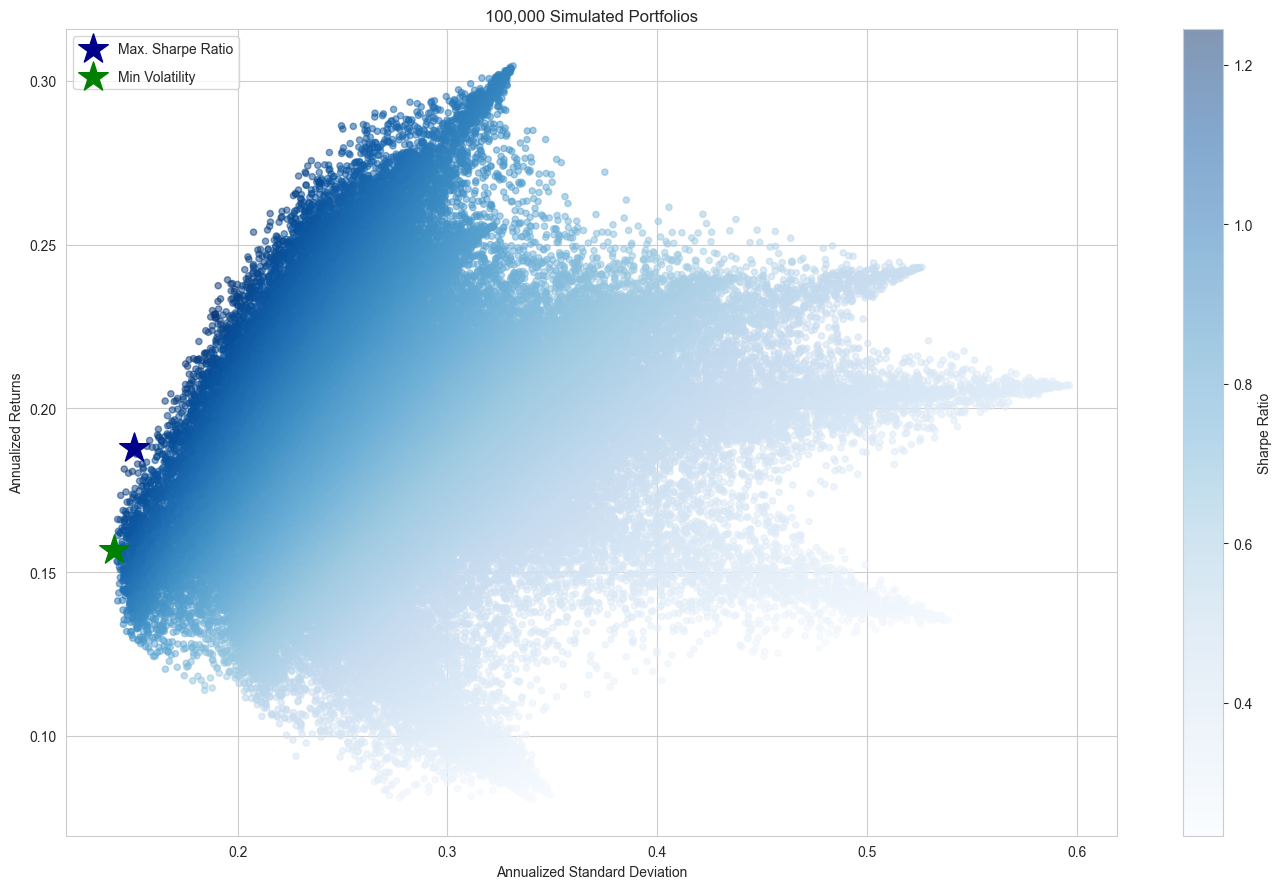

In [25]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [26]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [27]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [28]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [29]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [30]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [31]:
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [32]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Unfortunately, expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [33]:
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [34]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [35]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [36]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.278578            0.189240       0.709382
std                         0.068508            0.034365       0.181906
min                         0.140567            0.080685       0.233453
25%                         0.233964            0.168500       0.578636
50%                         0.265215            0.189774       0.700955
75%                         0.308740            0.209444       0.848494
max                         0.596335            0.304182       1.266763


In [37]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.160161
Annualized Returns               0.203386
Sharpe Ratio                     1.266763
Name: 36968, dtype: float64

### Get Max Sharpe PF

In [38]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [39]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.214319
sd     0.157483
sr     1.357729
dtype: float64

From simulated pf data

### Get Min Vol PF

In [40]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [41]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

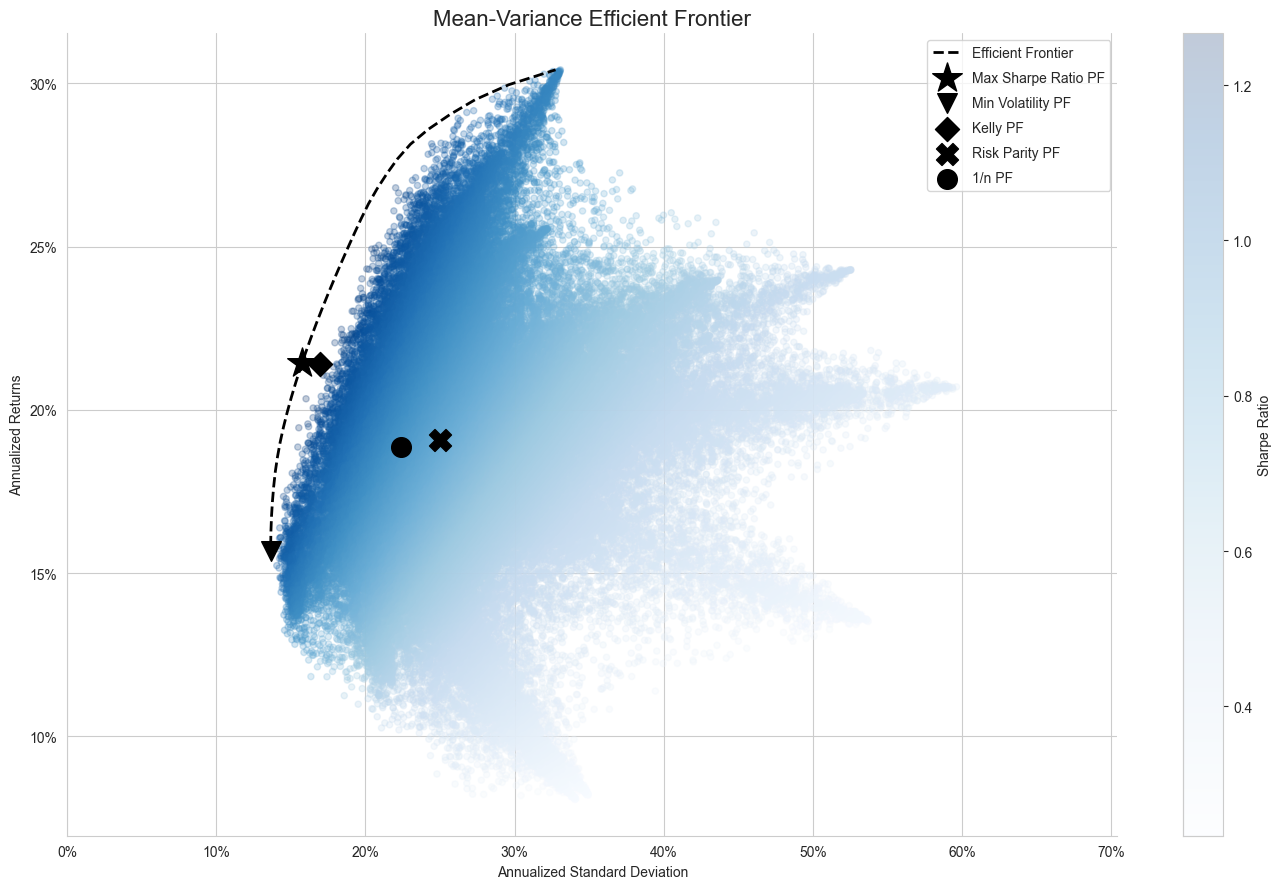

In [42]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();